In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("data/classtrain.csv")
test = pd.read_csv("data/classtest.csv")

train2 = pd.read_csv("data/classtrain02.csv")
train3 = pd.read_csv("data/classtrain03.csv")

      y  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0     1   1   1  -1   1  -1  -1   1  -1   1    1   -1   -1   -1   -1   -1
1     1   1   1  -1   1  -1   1   1   1   1    1   -1   -1   -1    1   -1
2    -1   1   1  -1  -1  -1  -1  -1   1  -1    1    1    1   -1    1    1
3     1  -1  -1   1   1   1  -1  -1   1   1   -1   -1    1    1    1   -1
4    -1   1  -1  -1   1  -1   1   1   1  -1   -1   -1    1   -1   -1    1
...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...
4995 -1   1  -1   1  -1  -1  -1  -1   1  -1    1   -1    1    1    1    1
4996  1   1   1   1  -1   1   1   1   1  -1   -1   -1    1    1    1   -1
4997 -1   1  -1  -1  -1   1   1  -1  -1   1    1   -1    1    1   -1   -1
4998  1   1  -1   1   1   1  -1   1   1  -1    1    1   -1   -1   -1   -1
4999 -1  -1  -1  -1   1  -1  -1   1   1   1   -1   -1    1   -1   -1    1

[5000 rows x 16 columns]


In [3]:
#calculates the information content of y
def infocontent(df):
    total = 0
    for y in df['y'].value_counts():
        total = total + ((y / len(df)) * math.log2((y / len(df))))   
    
    return -total

In [52]:
#returns the predicted y of the data using classification trees
def decisiontreeclass(data, traindata, y_average, minsize):
    
    #stopping conditions, branch terminates when it reaches minsize or if all the y values of the remaining data are the same
    #traindata builds the tree, data tests the tree
    if((len(traindata) <= minsize) | (len(traindata['y'].value_counts()) < 2)):
        y_class = 0
        
        if(len(traindata['y'].value_counts()) == 1):            
            y_class = traindata['y'].value_counts().index[0]
        else:
            if(traindata['y'].value_counts()[-1] > traindata['y'].value_counts()[1]):
                y_class = -1
            else:
                y_class = 1
        
        
        
        for d in data.index:
            y_average[d] = y_class
           
        return y_average
    
    
    hy = infocontent(traindata) # information content of y
    maxgain = 0 #maximium information gain
    xi = '' #x variable with maximum information gain
    
    for i in traindata:
        if((i != 'y')):
            hxy = 0
            for j in traindata[i].value_counts().index:
                xdata = traindata[traindata[i] == j]

                xprob = traindata[i].value_counts()[j] / len(traindata)
                
                hxy = hxy + (xprob * infocontent(xdata)) #conditional information content of y given x
                
            
            ig = hy - hxy #information gain
   
            if(ig > maxgain):
                maxgain = ig
                xi = i
            
    
    #splits the dataset into two subsets for recursion 
    posfinal = data[data[xi] == 1]
    negfinal = data[data[xi] == -1]
    
    posfinaltrain = traindata[traindata[xi] == 1]
    negfinaltrain = traindata[traindata[xi] == -1]
    
    #recursively constructs decision tree until minimum sample size is reached or passed
    # note that the left branch is -1 and the right branch is 1
    y_average = decisiontreeclass(negfinal, negfinaltrain, y_average, minsize)
    y_average = decisiontreeclass(posfinal, posfinaltrain, y_average, minsize)
    
    return y_average

In [53]:
y_pred = test['y'].copy()
decision_tree = decisiontreeclass(test, train, y_pred, 273)
print(decision_tree)

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
495    1
496   -1
497   -1
498   -1
499   -1
Name: y, Length: 500, dtype: int64


True

In [6]:
# Returns the number of false classifications of the predicted y against the actual y
def misclassifications(data, tree):
    classify = data['y'].copy()
    for i in data['y'].index:
        if(data['y'].iloc[i] == tree.iloc[i]):
            classify[i] = True
        else:
            classify[i] = False
            
    if(len(classify.value_counts()) == 1):
        return 0
    else:
        return classify.value_counts()[False]
    
    return classify.value_counts()[False]

[158, 158, 89, 89, 86, 35, 11]


Text(0.5, 1.0, '# of Misclassifications for Testing Data')

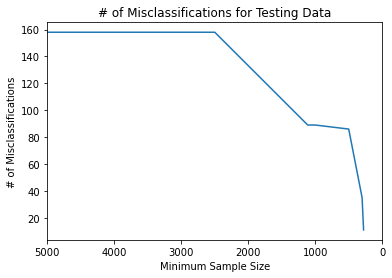

In [60]:
#Plot number of misclassifications against sample size
sizes = [4999, 2499, 1111, 999, 499, 299, 277]
errors = []
for s in sizes:
    temp_y = test['y'].copy()
    size_tree = decisiontreeclass(test, train, temp_y, s)
    errors.append(misclassifications(test, size_tree))
    
print(errors)
plt.plot(sizes, errors)
plt.xlim([5000, 0])
plt.xlabel("Minimum Sample Size")
plt.ylabel("# of Misclassifications")
plt.title("# of Misclassifications for Testing Data")

In [10]:
def newsigmadata(data, sigma):
    newdata = data.copy()
    np.random.seed(0)
    newdata['y'] = np.sign(newdata['X1']*.9 + newdata['X2']*.9**2 + newdata['X3']*.9**3 + newdata['X4']*.9**4
                   +newdata['X5']*.9**5 + np.random.normal(loc=0, scale=sigma, size=len(newdata)))
    
    return newdata

[236, 201, 140, 89, 37, 8, 11, 11]


Text(0.5, 1.0, '# of Misclassifications for Testing Data')

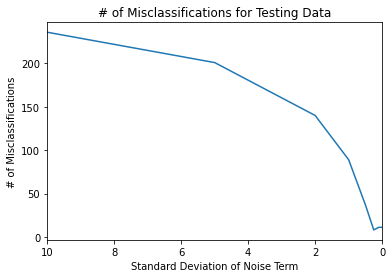

In [55]:
#plotting # of misclassifications against sigma
noise = [10, 5, 2, 1, .5, .25, .1, 0]
nerrors = []

for n in noise:    
    newTrain = newsigmadata(train, n)
    newTest = newsigmadata(test, n)
    new_y = newTest['y'].copy()
    noise_tree = decisiontreeclass(newTest, newTrain, new_y, 277)
    nerrors.append(misclassifications(newTest, noise_tree))
    

print(nerrors)
plt.plot(noise, nerrors)
plt.xlim([10, 0])
plt.xlabel("Standard Deviation of Noise Term")
plt.ylabel("# of Misclassifications")
plt.title("# of Misclassifications for Testing Data")

Text(0.5, 1.0, '# of Irrelevant Features Found in Tree')

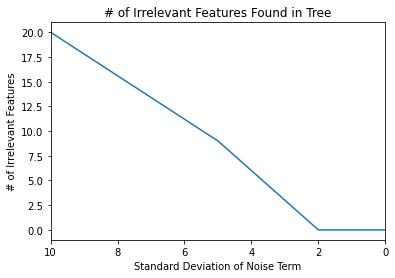

In [14]:
#plotting number of extra variables in the tree against sigma
extras = [20, 9, 0, 0, 0]
noises = [10, 5, 2, 1, 0]
plt.plot(noises, extras)
plt.xlim([10, 0])
plt.xlabel("Standard Deviation of Noise Term")
plt.ylabel("# of Irrelevant Features")
plt.title("# of Irrelevant Features Found in Tree")

In [56]:
#calculates the probability of each data point belonging to +1 using classification trees
def decisiontreelog(data, traindata, y_average, minsize):
    
    #stopping conditions, branch terminates when it reaches minsize or if all the y values of the remaining data are the same
    if((len(traindata) <= minsize) | (len(traindata['y'].value_counts()) < 2)):
        y_prob = 0
        
        if(len(traindata['y'].value_counts()) == 1):
            if(traindata['y'].value_counts().index[0] == 1):
                y_prob = 1
            else:
                y_prob = 0
        else:           
            y_prob = traindata['y'].value_counts()[1] / len(traindata)
            
        
        for d in data.index:
            y_average[d] = y_prob
        
        
        return y_average
    
    
    hy = infocontent(traindata) # information content of y
    maxgain = 0 #maximium information gain
    xi = '' #x variable with maximum information gain
    
    for i in traindata:
        if((i != 'y')):
            hxy = 0
            for j in traindata[i].value_counts().index:
                xdata = traindata[traindata[i] == j]

                xprob = traindata[i].value_counts()[j] / len(traindata)
                
                hxy = hxy + (xprob * infocontent(xdata)) #conditional information content of y given x
                
            
            ig = hy - hxy #information gain
                
            if(ig > maxgain):
                maxgain = ig
                xi = i
        
    
    #splits the dataset into two subsets for recursion 
    posfinal = data[data[xi] == 1]
    negfinal = data[data[xi] == -1]
    
    posfinaltrain = traindata[traindata[xi] == 1]
    negfinaltrain = traindata[traindata[xi] == -1]
    
    #recursively constructs decision tree until minimum sample size is reached or passed
    # note that the left branch is -1 and the right branch is 1
    y_average = decisiontreelog(negfinal, negfinaltrain, y_average, minsize)
    y_average = decisiontreelog(posfinal, posfinaltrain, y_average, minsize)
    
    return y_average    

In [57]:
y_pred2 = test['y'].copy().astype(float)
log_tree = decisiontreelog(test, train, y_pred2, 1237)
print(log_tree)

0      0.503667
1      0.000000
2      0.000000
3      0.503667
4      0.000000
         ...   
495    0.487158
496    0.224959
497    0.503667
498    0.487158
499    0.000000
Name: y, Length: 500, dtype: float64


In [21]:
#calculates the logistic error
def logerror(y, y_hat):
    log_y = np.log(y_hat)
    log_y_1 = np.log(1-y_hat)
    
    log_y[np.isneginf(log_y)] = 0
    log_y_1[np.isneginf(log_y_1)] = 0
    
    loss = np.mean(-y*(log_y) - (1-y)*log_y_1)
    return loss

C:\Users\castl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\castl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\castl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[0.4366928966858436, 0.3112202640889002, 0.06207863582727447, 0.01772488577774227, 0.13044322997554186, 0.2545818359756082, 0.033674286848600465]


C:\Users\castl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Logistic Error for Testing Data')

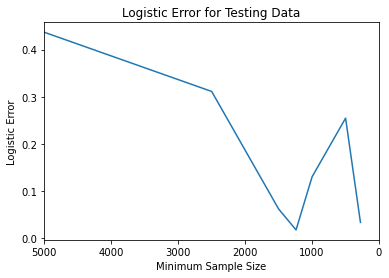

In [58]:
#plots logistic error against sample size
sizes = [4999, 2499, 1499, 1239, 999, 499, 277]
errors = []
for s in sizes:
    temp_y2 = test['y'].copy().astype(np.float64)
    size_tree2 = decisiontreelog(test, train, temp_y2, s)        
    errors.append(logerror(test['y'], size_tree2))
    
print(errors)
plt.plot(sizes, errors)
plt.xlim([5000, 0])
plt.xlabel("Minimum Sample Size")
plt.ylabel("Logistic Error")
plt.title("Logistic Error for Testing Data")

In [29]:
def gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y))

In [30]:
#finds the weight vector w using gradient descent
    #times: number of iterations
    #alpha: learning rate
def logregression(data, traindata, times, alpha):
    #traindata builds the model, data tests the model
    
    X = traindata.drop(['y'], axis=1)#X used to build the model
    X = X.replace(-1, 0)
    
    data_X = data.drop(['y'], axis=1)#X used to test the model
    data_X = data_X.replace(-1, 0)
    
    
    y = traindata['y'].replace(-1, 0)#y used to build the model
    y = traindata['y'].to_numpy()
    y.reshape(len(traindata), 1)
    
    data_y = data['y'].replace(-1, 0)#y used to test the model
    data_y = data['y'].to_numpy()
    data_y.reshape(len(data), 1)

    w = np.zeros((15, 1))#weight vector
    w = w[:, 0]

    errors = []# logistic error
    
    for t in range(times):   
        y_hat = 1 / (1 + np.exp(-np.dot(X, w)))
        data_y_hat = 1 / (1 + np.exp(-np.dot(data_X, w)))
        
        dw = gradient(X, y, y_hat)
        
        w = w - (alpha * dw)

        l = logerror(data_y, data_y_hat)
        errors.append(l)
    
    return w, errors
    

[ 0.06889237  0.10928993  0.1352834   0.10878083  0.11543099 -0.31732083
 -0.37053602 -0.3394795  -0.30583705 -0.37741211 -0.35383551 -0.35280307
 -0.31521357 -0.35085688 -0.31546552]


Text(0.5, 1.0, 'Logistic Error for Fitted Testing Model')

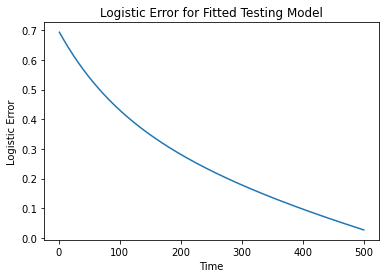

In [59]:
#plots logistic error against time
t = 500
w_pred, logloss = logregression(test, train, t, .000001)
print(w_pred)

plt.plot(range(1, t+1), logloss)
plt.xlabel("Time")
plt.ylabel("Logistic Error")
plt.title("Logistic Error for Fitted Testing Model")

In [4]:
svm_X = np.array([[-1, 1, -1, 1], [-1, -1, 1, 1]])
svm_y = np.array([-1, 1, 1, -1])
svm_y

array([-1,  1,  1, -1])

In [5]:
def kernel(Xi, Xj, c, degree):
    return (c + np.dot(Xi.T, Xj))**degree

In [124]:
#dual SVM problem
alpha = [1/8, 1/8, 1/8, 1/8]
print(np.sum(alpha) - (.5 *np.sum(np.outer(alpha, alpha) * np.outer(svm_y, svm_y) * kernel(svm_X, svm_X, 1, 2))))

0.25


In [132]:
decision_function = np.dot((alpha*svm_y), kernel(svm_X, svm_X, 1, 2))
print(decision_function)

0.0
